# 1.0 An end-to-end classification problem



## 1.1 Dataset description



We'll be looking at individual income in the United States. The **data** is from the **1994 census**, and contains information on an individual's **marital status**, **age**, **type of work**, and more. The **target column**, or what we want to predict, is whether individuals make less than or equal to 50k a year, or more than **50k a year**.

You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Adult).




## 1.2 Load Libraries, Train and Validation Sets

In [ ]:
#!pip install wandb

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import wandb
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn import set_config
set_config(display='diagram')

In [2]:
wandb.login(relogin=True)

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /home/kaio/.netrc


True

In [3]:
# save_code tracking all changes of the notebook and sync with Wandb
run = wandb.init(project="airbnb_eda", job_type="train_test", save_code=True)

wandb: Currently logged in as: mlops-kaio (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [178]:
local_path = run.use_artifact("airbnb_eda/data_train.csv:latest").file()
df_train = pd.read_csv(local_path)

In [179]:
df_train.head()

,room_type,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,Private room,3,1.0,1.0,3.0,279.0,2,60,2,5,...,4.54,4.67,4.41,4.68,f,5,0,5,0,1.59
1,Entire home/apt,2,1.5,1.0,2.0,674.0,1,30,1,5,...,5.00,5.00,4.97,4.86,t,1,1,0,0,1.19
2,Entire home/apt,2,1.0,1.0,1.0,286.0,3,1125,3,3,...,5.00,5.00,5.00,5.00,f,1,1,0,0,1.29
3,Entire home/apt,6,1.5,3.0,4.0,843.0,3,1125,3,3,...,4.97,4.91,4.91,4.76,f,1,1,0,0,1.58
4,Private room,4,1.0,1.0,3.0,150.0,1,30,1,1,...,4.33,4.17,4.83,4.50,f,2,0,2,0,0.13


## 1.3 Train and Dev split

In [180]:
# split-out train/validation and test dataset
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(labels="price",axis=1),
                                                    df_train["price"],
                                                    test_size=0.30,
                                                    random_state=42,
                                                    shuffle=True)

In [181]:
print("x train: {}".format(x_train.shape))
print("y train: {}".format(y_train.shape))
print("x val: {}".format(x_val.shape))
print("y val: {}".format(y_val.shape))

x train: (6866, 34)
y train: (6866,)
x val: (2943, 34)
y val: (2943,)


## 1.4 Removal Outliers

In [182]:
# Verify if columns[int64] has outliers (without data leakage!!!!!!!)

# data
x = x_train.select_dtypes("number").copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

print("X_train shape [original]: {}".format(x_train.shape))
print("X_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

# income with outliner
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

X_train shape [original]: (6866, 34)
X_train shape [outlier removal]: (6182, 34)


## 1.5 Encoding target variable

If a categorical target variable needs to be encoded for a classification predictive modeling problem, then the [LabelEncoder class](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) can be used.

In [183]:
# 
# just an experimentation
#

# drop=first erase redundant column
onehot = OneHotEncoder(sparse=False,drop="first")
# fit using x_train
onehot.fit(x_train["room_type"].values.reshape(-1,1))

x_val_aux = x_val.copy()
x_train_aux = x_train.copy()

# transform train and val
x_train_aux[onehot.get_feature_names_out()] = onehot.transform(
    x_train_aux["room_type"].values.reshape(-1,1))
x_val_aux[onehot.get_feature_names_out()] = onehot.transform(
    x_val_aux["room_type"].values.reshape(-1,1))

x_val_aux.head()

,room_type,accommodates,bathrooms_text,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,...,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,x0_Hotel room,x0_Private room,x0_Shared room
5281,Private room,2,1.0,1.0,2.0,3,1125,3,3,1125,...,5.00,t,2,0,2,0,0.09,0.0,1.0,0.0
6547,Entire home/apt,5,2.0,2.0,4.0,3,1125,3,3,1125,...,4.69,f,3,3,0,0,0.20,0.0,0.0,0.0
1568,Shared room,4,1.0,1.0,1.0,1,1125,1,1,1125,...,5.00,t,4,0,0,4,0.04,0.0,0.0,1.0
764,Entire home/apt,2,1.0,1.0,1.0,1,1125,1,1,1125,...,4.55,t,2,2,0,0,0.66,0.0,0.0,0.0
3350,Private room,1,1.0,1.0,1.0,1,20,1,1,20,...,4.93,f,2,0,2,0,1.00,0.0,1.0,0.0


In [187]:
onehot.get_feature_names_out()

array(['x0_Hotel room', 'x0_Private room', 'x0_Shared room'], dtype=object)

In [188]:
onehot.inverse_transform([[0, 0, 0]])

array([['Entire home/apt']], dtype=object)

In [189]:
# 1. just to review what are categorical columns
x_train.select_dtypes("object").columns.to_list()

['room_type', 'has_availability', 'instant_bookable']

In [ ]:
# 08 columns are object, transform them to Categorical

# transform object columns to Categorical
'''for name in x_train.select_dtypes("object").columns.to_list():
  onehot = OneHotEncoder(sparse=False,drop="first")
  # fit using x_train
  onehot.fit(x_train[name].values.reshape(-1,1))

  # transform train and test
  x_train[onehot.get_feature_names_out()] = onehot.transform(x_train[name].values.reshape(-1,1))
  x_val[onehot.get_feature_names_out()] = onehot.transform(x_val[name].values.reshape(-1,1))'''

In [ ]:
#cols=['room_type','has_availability','instant_bookable']

#x_train.drop(labels=cols,axis=1,inplace=True)
#x_val.drop(labels=cols,axis=1,inplace=True)

In [190]:
x_train.shape

(6182, 34)

## 1.6 Pipeline 

### 1.6.1 Column extractor

In [191]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self.feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self.feature_names ]

### 1.6.2 Categorical transformation

In [192]:
# Handling categorical features 
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True):
        self.new_features = new_features
        self.colnames = None

    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 

    def get_feature_names(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        df = X.copy()

        # customize feature?
        # how can I identify this one? EDA!!!!
        if self.new_features: 

            # minimize the cardinality of native_country feature
            df.loc[df['native_country']!=' United-States','native_country'] = 'non_usa' 

            # replace ? with Unknown
            edit_cols = ['native_country','occupation','workclass']
            for col in edit_cols:
                df.loc[df[col] == ' ?', col] = 'unknown'

            # decrease the cardinality of education feature
            hs_grad = [' HS-grad',' 11th',' 10th',' 9th',' 12th']
            elementary = [' 1st-4th',' 5th-6th',' 7th-8th']
            # replace
            df['education'].replace(to_replace = hs_grad,value = 'HS-grad',inplace = True)
            df['education'].replace(to_replace = elementary,value = 'elementary_school',inplace = True)

            # adjust marital_status feature
            married= [' Married-spouse-absent',' Married-civ-spouse',' Married-AF-spouse']
            separated = [' Separated',' Divorced']
            # replace 
            df['marital_status'].replace(to_replace = married ,value = 'Married',inplace = True)
            df['marital_status'].replace(to_replace = separated,value = 'Separated',inplace = True)

            # adjust workclass feature
            self_employed = [' Self-emp-not-inc',' Self-emp-inc']
            govt_employees = [' Local-gov',' State-gov',' Federal-gov']
            # replace elements in list.
            df['workclass'].replace(to_replace = self_employed ,value = 'Self_employed',inplace = True)
            df['workclass'].replace(to_replace = govt_employees,value = 'Govt_employees',inplace = True)

        # update column names
        self.colnames = df.columns      

        return df

#### 1.6.2.1 Evaluate

In [193]:
# 
# for validation purposes
#
model = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = model.fit_transform(x_train)
df.head()

,room_type,has_availability,instant_bookable
5023,Entire home/apt,t,f
7585,Entire home/apt,t,t
1598,Entire home/apt,t,f
9162,Private room,t,f
300,Private room,t,f


In [194]:
# 
# for validation purposes
#
#model = CategoricalTransformer(new_features=True)
#df_cat = model.fit_transform(df)
#df_cat.head()

In [195]:
# check the cardinality before and after transformation
x_train.select_dtypes("object").apply(pd.Series.nunique)

room_type           4
has_availability    2
instant_bookable    2
dtype: int64

In [ ]:
# check the cardinality before and after transformation
#df_cat.apply(pd.Series.nunique)

### 1.6.3 Numerical transformation

In [196]:
# transform numerical features
class NumericalTransformer( BaseEstimator, TransformerMixin ):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model = 1):
        self.model = model
        self.colnames = None

    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self

    # return columns names after transformation
    def get_feature_names(self):
        return self.colnames 

    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        df = X.copy()

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0: 
            scaler = MinMaxScaler()
            # transform data
            df = scaler.fit_transform(df)
        elif self.model == 1:
            scaler = StandardScaler()
            # transform data
            df = scaler.fit_transform(df)
        else:
            df = df.values

        return df

#### 1.6.3.1 Evaluate

In [197]:
# 
# for validation purposes
#
model = FeatureSelector(x_train.select_dtypes("number").columns.to_list())
df = model.fit_transform(x_train)
df.head()

,accommodates,bathrooms_text,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
5023,5,1.0,2.0,2.0,1,1125,1,1,1125,1125,...,4.73,4.67,4.47,4.60,4.33,1,1,0,0,0.26
7585,3,1.0,1.0,1.0,1,1125,1,20,1125,1125,...,3.50,4.50,4.75,4.50,3.75,1,1,0,0,0.10
1598,2,1.0,1.0,2.0,5,90,5,5,90,90,...,5.00,5.00,5.00,5.00,5.00,1,1,0,0,0.03
9162,2,1.5,1.0,1.0,1,1125,1,1,1125,1125,...,5.00,5.00,5.00,4.67,5.00,3,0,3,0,0.11
300,2,1.0,1.0,1.0,2,365,2,4,365,365,...,5.00,4.50,5.00,5.00,5.00,11,0,11,0,0.79


In [198]:
df.shape

(6182, 31)

In [199]:
# 
# for validation purposes
# 
# model 0: minmax
# model 1: standard
# model 2: without scaler
#
model = NumericalTransformer(model=1)
df_cat = model.fit_transform(df)
df_cat

array([[ 0.39528674, -0.62842561,  0.41344412, ..., -0.44795054,
        -0.12325651, -0.48213322],
       [-0.47916759, -0.62842561, -0.6582169 , ..., -0.44795054,
        -0.12325651, -0.66161873],
       [-0.91639475, -0.62842561, -0.6582169 , ..., -0.44795054,
        -0.12325651, -0.74014364],
       ...,
       [-0.47916759, -0.62842561, -0.6582169 , ...,  0.21805   ,
        -0.12325651, -0.74014364],
       [-0.91639475, -0.62842561, -0.6582169 , ..., -0.44795054,
        -0.12325651,  1.59316797],
       [-0.04194043, -0.62842561, -0.6582169 , ..., -0.44795054,
        -0.12325651,  0.42651217]])

### 1.6.4 Pipeline union (cat + num)

In [200]:
# Categrical features to pass down the categorical pipeline 
categorical_features = x_train.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline 
numerical_features = x_train.select_dtypes("number").columns.to_list()

# Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline(steps = [('cat_selector', FeatureSelector(categorical_features)),
                                         #('cat_transformer', CategoricalTransformer()),
                                         #('cat_encoder','passthrough')
                                         ('cat_encoder',OneHotEncoder(sparse=False,drop="first"))
                                         ]
                                )

# Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(numerical_features)),
                                       ('num_transformer', NumericalTransformer())
                                       ]
                              )

# Combining numerical and categorical piepline into one full big pipeline horizontally 
# using FeatureUnion
full_pipeline_preprocessing = FeatureUnion(transformer_list = [('cat_pipeline', categorical_pipeline),
                                                               ('num_pipeline', numerical_pipeline)
                                                               ]
                                           )

#### 1.6.4.1 Evaluate

In [201]:
full_pipeline_preprocessing

FeatureUnion(transformer_list=[('cat_pipeline',
                                Pipeline(steps=[('cat_selector',
                                                 FeatureSelector(feature_names=['room_type',
                                                                                'has_availability',
                                                                                'instant_bookable'])),
                                                ('cat_encoder',
                                                 OneHotEncoder(drop='first',
                                                               sparse=False))])),
                               ('num_pipeline',
                                Pipeline(steps=[('num_selector',
                                                 FeatureSelector(feature_names=['accommodates',
                                                                                'bathrooms_text',
                                                                                'bedrooms',
                                                                                'beds...
                                                                                'review_scores_cleanliness',
                                                                                'review_scores_checkin',
                                                                                'review_scores_communication',
                                                                                'review_scores_location',
                                                                                'review_scores_value',
                                                                                'calculated_host_listings_count',
                                                                                'calculated_host_listings_count_entire_homes',
                                                                                'calculated_host_listings_count_private_rooms',
                                                                                'calculated_host_listings_count_shared_rooms', ...])),
                                                ('num_transformer',
                                                 NumericalTransformer())]))])

In [202]:
# 
# for validate purposes
#
new_data = full_pipeline_preprocessing.fit_transform(x_train)
catnames = full_pipeline_preprocessing.get_params()["cat_pipeline"][1].get_feature_names_out().tolist()
numnames = full_pipeline_preprocessing.get_params()["num_pipeline"][1].get_feature_names()
df = pd.DataFrame(new_data,columns = catnames + numnames)
df.head()

,room_type_Hotel room,room_type_Private room,room_type_Shared room,has_availability_t,instant_bookable_t,accommodates,bathrooms_text,bedrooms,beds,minimum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0.0,0.0,0.0,1.0,0.0,0.395287,-0.628426,0.413444,-0.301099,-0.714658,...,0.082544,-0.579212,-0.976726,-0.717192,-0.691001,-0.306545,-0.262293,-0.447951,-0.123257,-0.482133
1,0.0,0.0,0.0,1.0,1.0,-0.479168,-0.628426,-0.658217,-0.825141,-0.714658,...,-2.232163,-1.051264,-0.268834,-0.993108,-1.906363,-0.306545,-0.262293,-0.447951,-0.123257,-0.661619
2,0.0,0.0,0.0,1.0,0.0,-0.916395,-0.628426,-0.658217,-0.301099,0.782721,...,0.590651,0.337126,0.363213,0.386469,0.712952,-0.306545,-0.262293,-0.447951,-0.123257,-0.740144
3,0.0,1.0,0.0,1.0,0.0,-0.916395,-0.093017,-0.658217,-0.825141,-0.714658,...,0.590651,0.337126,0.363213,-0.524052,0.712952,-0.177599,-0.327909,1.550051,-0.123257,-0.650401
4,0.0,1.0,0.0,1.0,0.0,-0.916395,-0.628426,-0.658217,-0.825141,-0.340313,...,0.590651,-1.051264,0.363213,0.386469,0.712952,0.338188,-0.327909,6.878055,-0.123257,0.112413


In [203]:
df.shape

(6182, 36)

## 1.7 Modeling and Training

In [235]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("regressor",
                          DecisionTreeRegressor(
                              criterion="squared_error",
                              splitter="best",
                              max_depth=10,
                              random_state=42
                          ))])

# training 
pipe.fit(x_train,y_train)

# final model
predict = pipe.predict(x_val)

In [238]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("Mean Absolute Error", mean_absolute_error(y_val, predict))
print("Root Mean Squared Error", mean_squared_error(y_val, predict, squared=False))
print("R2 Score", r2_score(y_val, predict))

Mean Absolute Error 571.2469991357829
Root Mean Squared Error 3235.7584540521857
R2 Score -1.1886321975223675


In [220]:
pipe['regressor'].get_depth()

10

In [221]:
# full pipeline
features_full = pipe.named_steps['full_pipeline']

# get columns names from categorial columns
features_cat = features_full.get_params()["cat_pipeline"]
features_cat = features_cat[1].get_feature_names_out().tolist()
features_cat

['room_type_Hotel room',
 'room_type_Private room',
 'room_type_Shared room',
 'has_availability_t',
 'instant_bookable_t']

In [222]:
# get columns names from numerical columns
features_num = features_full.get_params()["num_pipeline"][1].get_feature_names()
features_num

['accommodates',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'reviews_per_month']

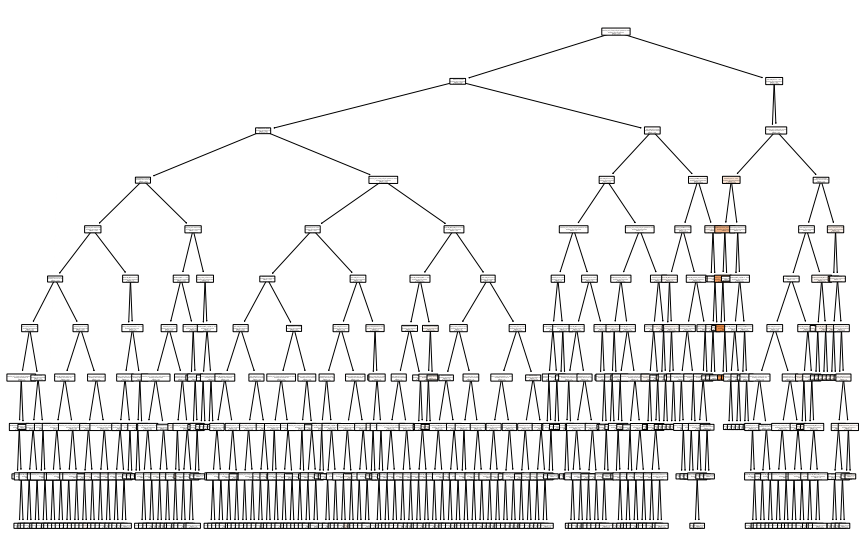

In [224]:
'''from sklearn.tree import plot_tree # to draw a classification tree
fig, ax = plt.subplots(1,1, figsize=(15, 10))
plot_tree(pipe["regressor"], 
          filled=True, 
          rounded=True, 
          feature_names=features_cat+features_num, ax=ax)
plt.show()'''